# Logistic Regression Model to Predict Which Film Will Be Rented Next Month

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 

from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split      
from sklearn.linear_model import LogisticRegression   

#%matplotlib inline

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


In [3]:
# Create a query to extract relevent information to build the prediction model.

query = '''SELECT f.film_id, title, c.name as category_name, f.rating, f.length, f.rental_duration, f.special_features, f.rental_rate, f.release_year, total_rentings
FROM (SELECT count(rental_date) as total_rentings, i.film_id
      FROM rental as r
      JOIN inventory as i
      USING (inventory_id)
      GROUP BY film_id
) t
RIGHT JOIN film as f
USING (film_id)
LEFT JOIN film_category as fa
USING (film_id)
LEFT JOIN category as c
USING (category_id);
'''

In [4]:
# Read the data into a Pandas dataframe.

data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,category_name,rating,length,rental_duration,special_features,rental_rate,release_year,total_rentings
0,1,ACADEMY DINOSAUR,Documentary,PG,86,6,"Deleted Scenes,Behind the Scenes",0.99,2006,24.0
1,2,ACE GOLDFINGER,Horror,G,48,3,"Trailers,Deleted Scenes",4.99,2006,7.0
2,3,ADAPTATION HOLES,Documentary,NC-17,50,7,"Trailers,Deleted Scenes",2.99,2006,12.0
3,4,AFFAIR PREJUDICE,Horror,G,117,5,"Commentaries,Behind the Scenes",2.99,2006,23.0
4,5,AFRICAN EGG,Family,G,130,6,Deleted Scenes,2.99,2006,12.0


## Exploring Data

In [ ]:
data.shape

In [ ]:
data.info()

In [ ]:
data.film_id.nunique()

# 1000 films in total in our dataset

In [ ]:
data.rating.value_counts()

In [ ]:
data.release_year.value_counts()

# Only 1 value(2006) will drop column later.

In [ ]:
data.special_features.value_counts()

In [ ]:
data.rental_duration.value_counts()

## Data Cleaning

In [5]:
#Changing movie title to lower case using str.title()

data['title'] = data['title'].str.title()

In [6]:
# Dropping release_year column since it only has 1 single value, therefore not useful to build our model.

data.drop(["release_year"], axis=1, inplace=True)

In [7]:
#Checking nulls

data.isna().sum()

film_id              0
title                0
category_name        0
rating               0
length               0
rental_duration      0
special_features     0
rental_rate          0
total_rentings      42
dtype: int64

In [8]:
# We have 43 nulls in rentings. It means 43 movies were not rented at all last year.
# Replace nulls with 0.

data['total_rentings'] = data['total_rentings'].fillna(0.0)

In [9]:
data.isna().sum()

film_id             0
title               0
category_name       0
rating              0
length              0
rental_duration     0
special_features    0
rental_rate         0
total_rentings      0
dtype: int64

### Numerical Variables

In [10]:
numerical = data.select_dtypes(include = np.number)
numerical.describe()

,film_id,length,rental_duration,rental_rate,total_rentings
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,500.500000,115.272000,4.985000,2.980000,16.04500
std,288.819436,40.426332,1.411654,1.646393,7.34908
min,1.000000,46.000000,3.000000,0.990000,0.00000
25%,250.750000,80.000000,4.000000,0.990000,11.00000
50%,500.500000,114.000000,5.000000,2.990000,16.00000
75%,750.250000,149.250000,6.000000,4.990000,21.00000
max,1000.000000,185.000000,7.000000,4.990000,34.00000


 #### Checking for multicollinearity

In [ ]:
#Creating a Correlation plot:

correlations_matrix = numerical.corr(method="spearman")
correlations_matrix

In [ ]:
corr_matrix=numerical.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

None of the numerical features have a high correlation with one another. However for our model (logistic regression) we don't need Multicollinearity for the model to perform better.

In [ ]:
# Plotting Distribution of numerical features

sns.distplot(numerical["length"])
sns.displot(numerical["rental_duration"])
sns.displot(numerical["total_rentings"])
sns.displot(numerical["rental_rate"])

In [ ]:
# Applying standard scaler to see if we can make "length" look more normal distributed

transformer = StandardScaler().fit(numerical)
num_normalized = transformer.transform(numerical)
num_trans = pd.DataFrame(num_normalized)
num_trans.columns = numerical.columns
num_trans.head()

In [ ]:
sns.distplot(num_trans["length"])


Transforming our numerical variables did not make any difference in distribution. However for our model (logistic regression) we don't need our variables to be normally distributed.

In [ ]:
#numerical2=numerical.copy()

In [ ]:
#Applying MinMaxScaler to see if it makes any difference to our model

#from sklearn.preprocessing import MinMaxScaler
#transformer = MinMaxScaler().fit(numerical2)
#num_normalized = transformer.transform(numerical2)
#num_normalized = pd.DataFrame(num_normalized)
#num_normalized.describe()

### Categorical Variables

In [11]:
#Get categorical data

cat = data.select_dtypes(include = np.object)
cat.head()

,title,category_name,rating,special_features
0,Academy Dinosaur,Documentary,PG,"Deleted Scenes,Behind the Scenes"
1,Ace Goldfinger,Horror,G,"Trailers,Deleted Scenes"
2,Adaptation Holes,Documentary,NC-17,"Trailers,Deleted Scenes"
3,Affair Prejudice,Horror,G,"Commentaries,Behind the Scenes"
4,African Egg,Family,G,Deleted Scenes


#### Categorical Variables Visualization

In [12]:
# TARGET VARIABLE: creating a function to assign 0 as not rented at all last year (between 2006-02-14  - 2005-05-24) and 1 as rented last year.
# Has the movie been rented last year? (binary: “1”, means “Yes”, “0” means “No”)

rentals = []

for row in data['total_rentings']:
    if row == 0:
        rentals.append(0)
    else:
        rentals.append(1)   

In [13]:
# adding rentals list as a column in our dataset. This column will be our target variable.

data['rentals'] = rentals

In [14]:
data.rentals.value_counts()

# Since all the movies were rented at least once last year, I am going to calculate the median of total_rentings and establish that above median is  

1    958
0     42
Name: rentals, dtype: int64

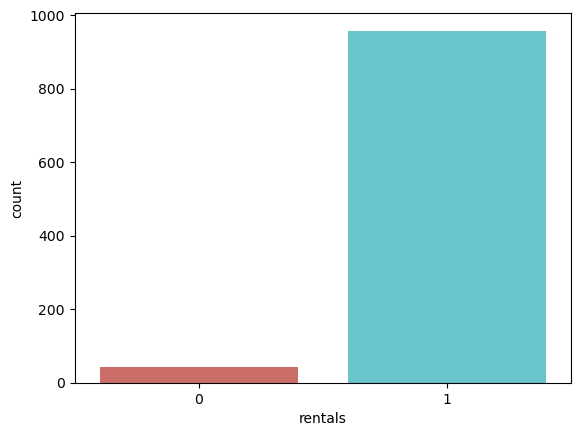

In [15]:
sns.countplot(x=data['rentals'], data=data, palette='hls')
plt.show()

We can see our data is severely imbalanced, therefore it could cause our prediction model to be biased towards the most common class, in this case "1" - film rented last year.

In [ ]:
#lets visualize our categorical independent variables against our Target "rentals"

table=pd.crosstab(data.special_features,data.rentals)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Special Features vs Last Year Rental')
plt.xlabel('Special Features')
plt.ylabel('Last_Year_Rental')
plt.figure(figsize=(10,6))

#Special Features might be a good predictor of our target variable.

In [ ]:
pd.crosstab(data.rating,rentals).plot(kind='bar')
plt.title('Film Rating vs Last Year Rental')
plt.xlabel('Rating')
plt.ylabel('Last Year Rental')

#Film Rating may not be a good predictor of our target variable.

In [ ]:
pd.crosstab(data.category_name,data.rentals).plot(kind='bar')
plt.title('Film Category vs Last Year Rental')
plt.xlabel('category_name')
plt.ylabel('Last Year Rental')


# Film Category might be a good predictor of our target variable.

#### Encoding Categoricals (Using ONEHOTENCODER)


In [16]:
cat = cat.drop(['title'], axis=1) 

In [ ]:
#Using GETDUMMIES
#categorical = pd.get_dummies(cat, columns=['category_name', 'rating', 'special_features'])
#categorical.head()

In [17]:
encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(cat)

OneHotEncoder(drop='first')

In [18]:
encoded = encoder.transform(cat).toarray() 
categorical = pd.DataFrame(encoded)

In [19]:
# Add column names to the dataframe
categorical.columns = encoder.get_feature_names_out()
categorical.head()

,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split and Training Model

In [23]:
y = data['rentals'] # Our TARGET. We want to predict if Movie will be rented next month(0 and 1).
#X = pd.concat((numerical, categorical), axis=1) #concats numerical variables and encoded categorical variables

X = pd.concat((numerical, categorical), axis=1)

In [24]:
X.shape

(1000, 38)

In [25]:
# Separating training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100) #30% for test set 70% for train test.

In [35]:
X_test.shape

(300, 38)

In [27]:
X_train.shape

(700, 38)

In [40]:
# Training our data using Logistic Regression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)   

In [41]:
# How well did our model perform? Let's check the predictions (We predict on the testing dataset)

predictions = classification.predict(X_test)


In [42]:
pd.Series(predictions).value_counts() 

1    287
0     13
dtype: int64

In [43]:
#Let's check the real/True values

y_test.value_counts() 

1    287
0     13
Name: rentals, dtype: int64

#### Confusion Matrix to Evaluate Performance of Model

In [44]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

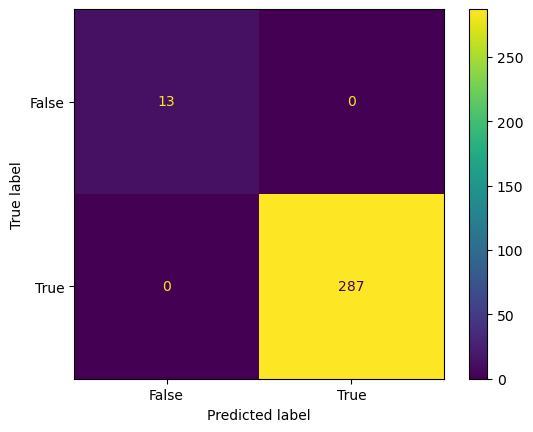

In [45]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

287 values were True and I predicted 287.

In [56]:
# Accuracy
classification.score(X_test, y_test)

# Accuracy of 100%

1.0

In [ ]:
#Create dataframe for visualising the differences between True and Predicted values

results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['diff'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results